In [ ]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/MC886/TrabFinal/archive.zip > /dev/null

replace Br35H-Mask-RCNN/TEST/annotations_test.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Import data

In [ ]:
def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        sample.append(filename)
    return sample

no_path = '/content/no/*.jpg'
yes_path = '/content/yes/*.jpg'

train_no = importing_data(no_path)
train_yes = importing_data(yes_path)

df_train_no = pd.DataFrame({'image':train_no, 'label': 'Healthy'})
df_train_yes = pd.DataFrame({'image':train_yes, 'label': 'Affected'})
train_data = pd.concat([df_train_no, df_train_yes])
train_data

,image,label
0,/content/no/no1292.jpg,Healthy
1,/content/no/no361.jpg,Healthy
2,/content/no/no785.jpg,Healthy
3,/content/no/no358.jpg,Healthy
4,/content/no/no1387.jpg,Healthy
...,...,...
1495,/content/yes/y1269.jpg,Affected
1496,/content/yes/y646.jpg,Affected
1497,/content/yes/y294.jpg,Affected
1498,/content/yes/y153.jpg,Affected


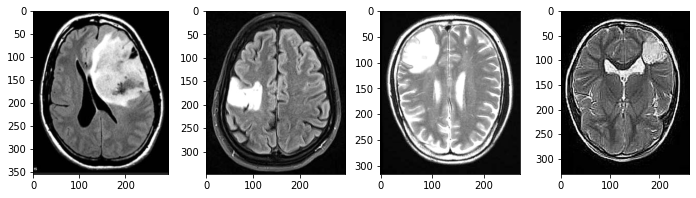

In [ ]:
f, axs = plt.subplots(1, 4, figsize=(12,3))
for i, file_ in enumerate(train_data["image"][-4:]):
    axs[i].imshow(Image.open(file_).convert('L'), cmap='gray')

# Spliting data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

# Model definition

In [ ]:
import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                    

# Additional metrics

In [ ]:
from keras import backend as K

class_index = {'Affected': 0, 'Healthy': 1}
# So we need to invert the label in metrics

def recall_m(y_true, y_pred):
    y_true = 1-y_true
    y_pred = 1-K.cast_to_floatx(K.reshape(K.argmax(y_pred), (-1, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = 1-y_true
    y_pred = 1-K.cast_to_floatx(K.reshape(K.argmax(y_pred), (-1, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Fitting function

In [ ]:
def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics = ['acc',f1_m,precision_m, recall_m])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=3,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 4,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

# Cross-Validation function

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

k_fold = 5
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
tf.compat.v1.enable_eager_execution()
def CV_training(X_train_val):
    
    cv_histories = []
    
    kf = KFold(n_splits=k_fold, random_state=42)
    
    for i, (train_index, val_index) in enumerate(kf.split(X_train_val)):
        
        datagen = ImageDataGenerator(rescale = 1./255)
        
        train_set = datagen.flow_from_dataframe(X_train_val.iloc[train_index],
                                                directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(X_train_val.iloc[val_index],
                                              directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))

    return cv_histories

cv_results = CV_training(X_train_val)

Found 2160 validated image filenames belonging to 2 classes.
Found 540 validated image filenames belonging to 2 classes.
Training on Fold:  1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Epoch 1/50
216/216 [==============================] - 18s 66ms/step - loss: 0.6358 - acc: 0.6440 - f1_m: 0.6615 - precision_m: 0.6306 - recall_m: 0.7583 - val_loss: 0.5441 - val_acc: 0.7444 - val_f1_m: 0.7103 - val_precision_m: 0.7039 - val_recall_m: 0.7392 - lr: 1.0000e-04
Epoch 2/50
216/216 [==============================] - 14s 64ms/step - loss: 0.5536 - acc: 0.7255 - f1_m: 0.7212 - precision_m: 0.7115 - recall_m: 0.7982 - val_loss: 0.4918 - val_acc: 0.7537 - val_f1_m: 0.7543 - val_precision_m: 0.6980 - val_recall_m: 0.8719 - lr: 1.0000e-04
Epoch 3/50
216/216 [==============================] - 14s 64ms/step - loss: 0.4875 - acc: 0.7861 - f1_m: 0.7859 - precision_m: 0.7632 - recall_m: 0.8526 - val_loss: 0.4178 - val_acc: 0.8167 - val_f1_m: 0.8017 - val_precision_m: 0.7827 - val_recall_m: 0.8509 - lr: 1.0000e-04
Epoch 4/50
216/216 [==============================] - 14s 63ms/step - loss: 0.4083 - acc: 0.8259 - f1_m: 0.8160 - precision_m: 0.8164 - recall_m: 0.8604 - val_loss: 0.3406 - v

# Plotting results

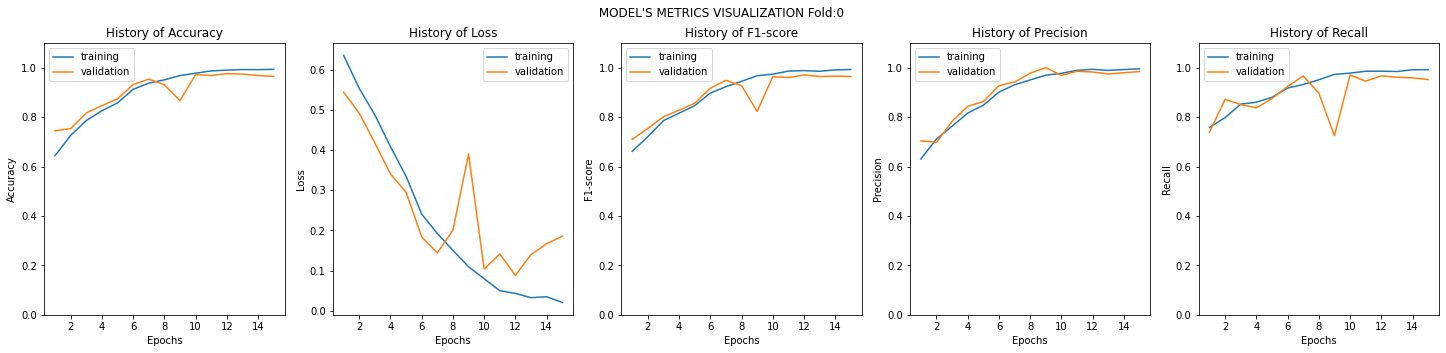

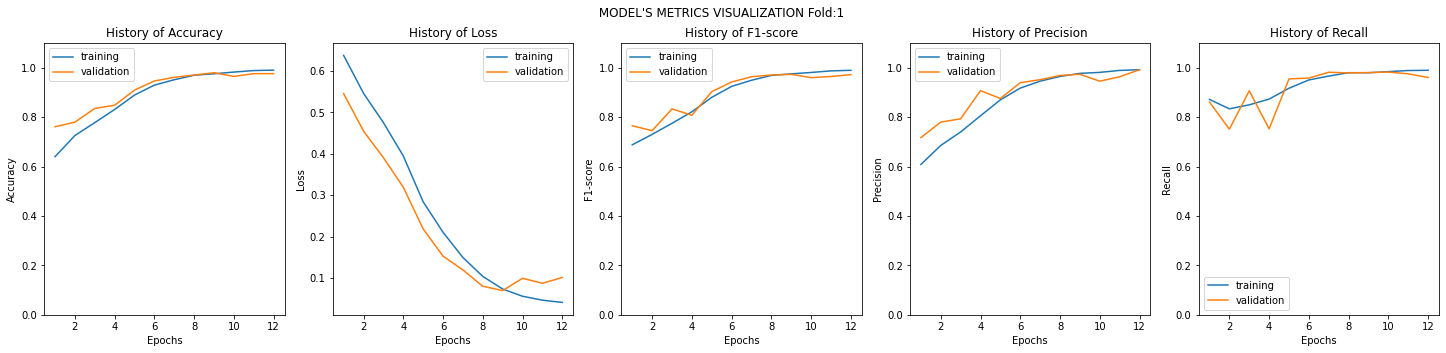

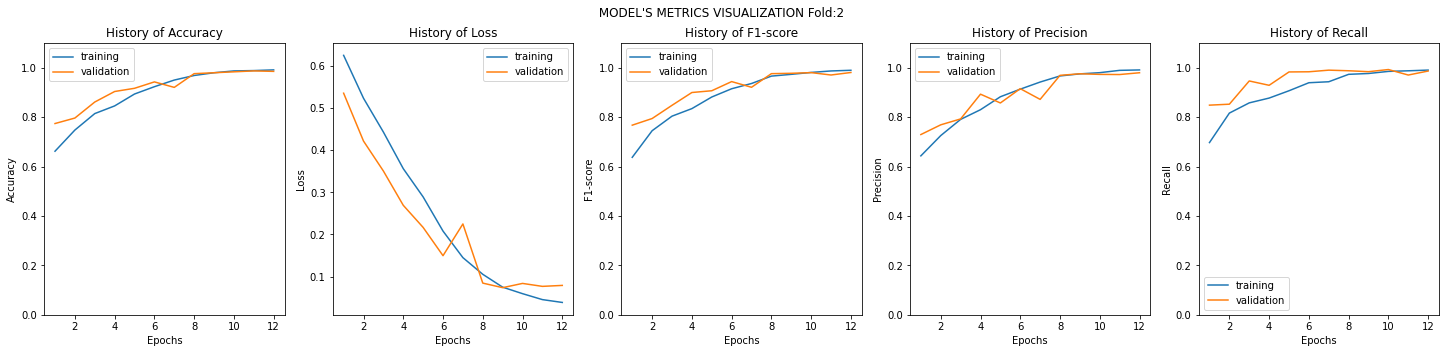

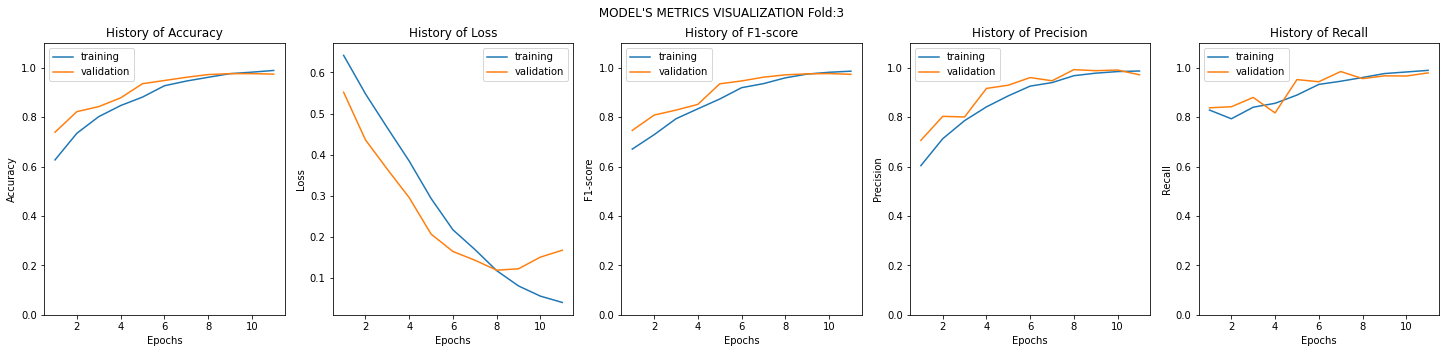

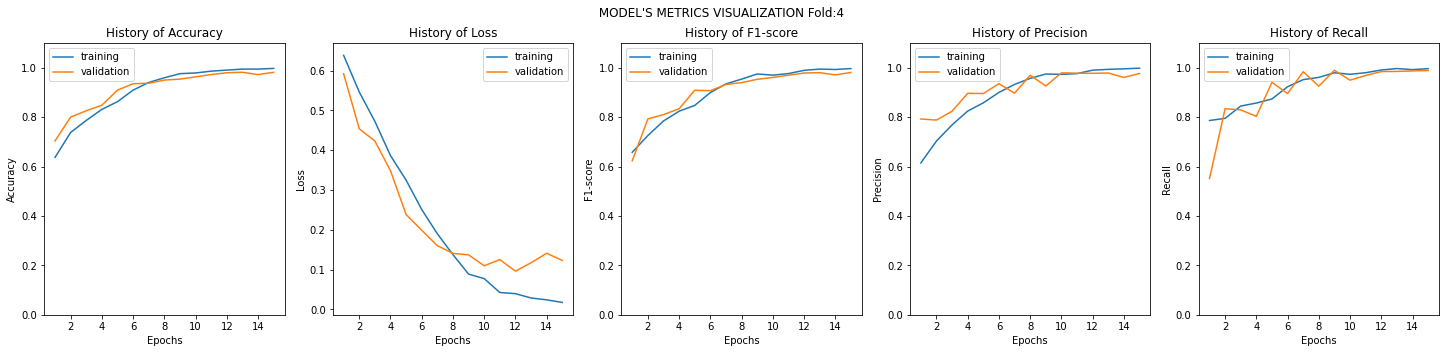

In [ ]:
def Plot(results):
    
    for i, fold in enumerate(results):
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']

        loss = fold.history['loss']
        val_loss = fold.history['val_loss']

        f1_m = fold.history['f1_m']
        val_f1_m = fold.history['val_f1_m']

        precision_m = fold.history['precision_m']
        val_precision_m = fold.history['val_precision_m']

        recall_m = fold.history['recall_m']
        val_recall_m = fold.history['val_recall_m']

    
        fig, axs = plt.subplots(1,5, figsize= (25,5))
        fig.suptitle(f" MODEL'S METRICS VISUALIZATION Fold:{i}")

        def plot_metric(hist, val_hist, ax, title, y_range=None):
            ax.plot(range(1, len(hist) + 1), hist)
            ax.plot(range(1, len(val_hist) + 1), val_hist)
            ax.set_title(f'History of {title}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(title)
            ax.legend(['training', 'validation'])
            if y_range != None:
                ax.set_ylim(*y_range)

        plot_metric(acc, val_acc, axs[0], 'Accuracy', (0,1.1))
        plot_metric(loss, val_loss, axs[1], 'Loss')
        plot_metric(f1_m, val_f1_m, axs[2], 'F1-score', (0,1.1))
        plot_metric(precision_m, val_precision_m, axs[3], 'Precision', (0,1.1))
        plot_metric(recall_m, val_recall_m, axs[4], 'Recall', (0,1.1))

        plt.show()
    
Plot(cv_results)

In [ ]:
mean_val_acc = np.mean([result.history['val_acc'][-1] for result in cv_results])
mean_val_recall_m = np.mean([result.history['val_recall_m'][-1] for result in cv_results])
mean_val_precision_m = np.mean([result.history['val_precision_m'][-1] for result in cv_results])
mean_val_f1_m = np.mean([result.history['val_f1_m'][-1] for result in cv_results])
print(f'Mean validation accuracy between {k_fold}-folds: {mean_val_acc}')
print(f'Mean validation recall between {k_fold}-folds: {mean_val_recall_m}')
print(f'Mean validation precision between {k_fold}-folds: {mean_val_precision_m}')
print(f'Mean validation F1-score between {k_fold}-folds: {mean_val_f1_m}')

Mean validation accuracy between 5-folds: 0.9762963056564331
Mean validation recall between 5-folds: 0.9733113050460815
Mean validation precision between 5-folds: 0.9807877659797668
Mean validation F1-score between 5-folds: 0.9742389798164368


We can see that our model surpassed the baseline from [Sírio Libanês](https://www.hospitalsiriolibanes.org.br/hospital/especialidades/centro-oncologia/cerebral/Paginas/diagnosticos.aspx) article of 95% detection rate.

In [ ]:
!mv /content/Brain_model_best.h5 /content/drive/MyDrive/MC886/TrabFinal/